In [1]:
import glob

import metpy
import xarray as xr
import matplotlib.pyplot as plt

## Vapour pressure

#### Read AWRA data

In [2]:
awra_vp_files = sorted(glob.glob('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/vapour_pressure/vapour_pressure_*.nc'))

In [3]:
awra_vp_files[66]

'/g/data/fj8/BoM/AWRA/DATA/CLIMATE/vapour_pressure/vapour_pressure_2016.nc'

In [4]:
ds_awra_vp = xr.open_mfdataset(awra_vp_files[66])

#### Read AGCD data

In [5]:
#agcd_vp9am_files = sorted(glob.glob('/g/data/xv83/agcd-csiro/vp-9am/daily/vp-9am_AGCD-CSIRO_r005_*_daily.nc'))
#agcd_vp9am_files[45]
agcd_vp9am_file = '/g/data/zv2/agcd/v1-0-1/vapourpres_h09/mean/r005/01day/agcd_v1-0-1_vapourpres_h09_mean_r005_daily_2016.nc'

In [6]:
ds_agcd_vp9am = xr.open_dataset(agcd_vp9am_file)

In [7]:
#agcd_vp3pm_files = sorted(glob.glob('/g/data/xv83/agcd-csiro/vp-3pm/daily/vp-3pm_AGCD-CSIRO_r005_*_daily.nc'))
#agcd_vp3pm_files[45]
agcd_vp3pm_file = '/g/data/zv2/agcd/v1-0-1/vapourpres_h15/mean/r005/01day/agcd_v1-0-1_vapourpres_h15_mean_r005_daily_2016.nc'

In [8]:
ds_agcd_vp3pm = xr.open_dataset(agcd_vp3pm_file)

In [9]:
daily_vapourpres = (ds_agcd_vp9am['vapourpres'].values * 0.2) + (ds_agcd_vp3pm['vapourpres'].values * 0.8)

In [10]:
coords = {
    'time': ds_agcd_vp9am['time'],
    'lat': ds_agcd_vp9am['lat'],
    'lon': ds_agcd_vp9am['lon'],
}

da_agcd_vp = xr.DataArray(
    data = daily_vapourpres,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
    attrs = ds_agcd_vp9am['vapourpres'].attrs
)

ds_agcd_vp = xr.Dataset({'vapourpres': da_agcd_vp}, attrs=ds_agcd_vp9am.attrs)

In [11]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

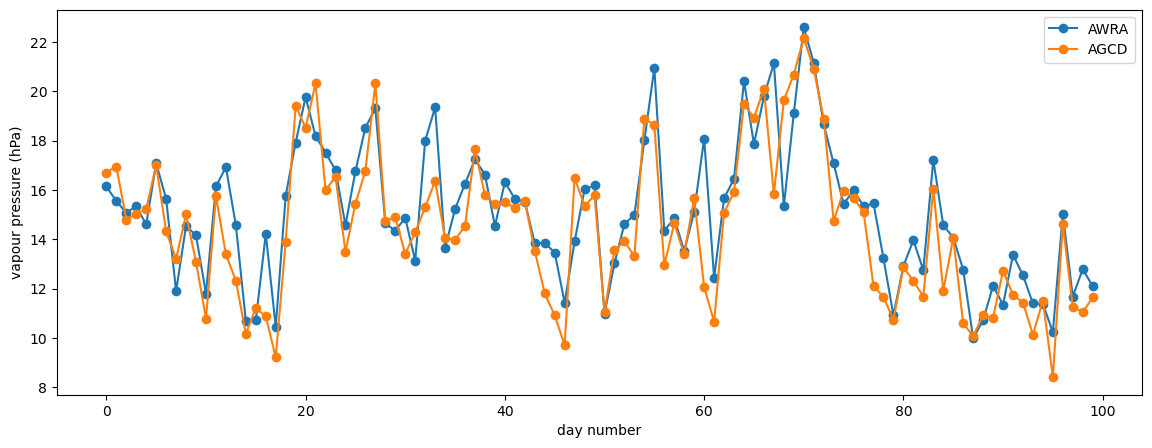

In [12]:
lat, lon = city_lat_lon['Melbourne']
point_awra_vp = ds_awra_vp['vapour_pressure'].sel({'latitude': lat, 'longitude': lon}, method='nearest')
point_agcd_vp = ds_agcd_vp['vapourpres'].sel({'lat': lat, 'lon': lon}, method='nearest')

fig = plt.figure(figsize=[14, 5])
plt.plot(point_awra_vp.values[0:100], marker='o', label='AWRA')
plt.plot(point_agcd_vp.values[0:100], marker='o', label='AGCD')

plt.ylabel('vapour pressure (hPa)')
plt.xlabel('day number')
plt.legend()
plt.show()

## Relative humidity

In [13]:
agcd_tmin_file = '/g/data/zv2/agcd/v1-0-1/tmin/mean/r005/01day/agcd_v1-0-1_tmin_mean_r005_daily_2016.nc'
agcd_tmax_file = '/g/data/zv2/agcd/v1-0-1/tmax/mean/r005/01day/agcd_v1-0-1_tmax_mean_r005_daily_2016.nc'

In [14]:
ds_agcd_tmin = xr.open_dataset(agcd_tmin_file)
ds_agcd_tmax = xr.open_dataset(agcd_tmax_file)

In [15]:
daily_tas = (ds_agcd_tmin['tmin'].values[1:] * 0.15) + (ds_agcd_tmax['tmax'].values[:-1] * 0.85)

In [16]:
coords = {
    'time': ds_agcd_tmin['time'][1:],
    'lat': ds_agcd_tmin['lat'],
    'lon': ds_agcd_tmin['lon'],
}

da_agcd_tas = xr.DataArray(
    data = daily_tas,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
    attrs = ds_agcd_tmin['tmin'].attrs
)
del da_agcd_tas.attrs['cell_methods']
da_agcd_tas.attrs['long_name'] = 'Daily weighted mean air temperature'
da_agcd_tas.attrs['units'] = 'degC'

ds_agcd_tas = xr.Dataset({'tas': da_agcd_tas}, attrs=ds_agcd_tmin.attrs)

In [41]:
da_agcd_vps = metpy.calc.saturation_vapor_pressure(ds_agcd_tas['tas'])

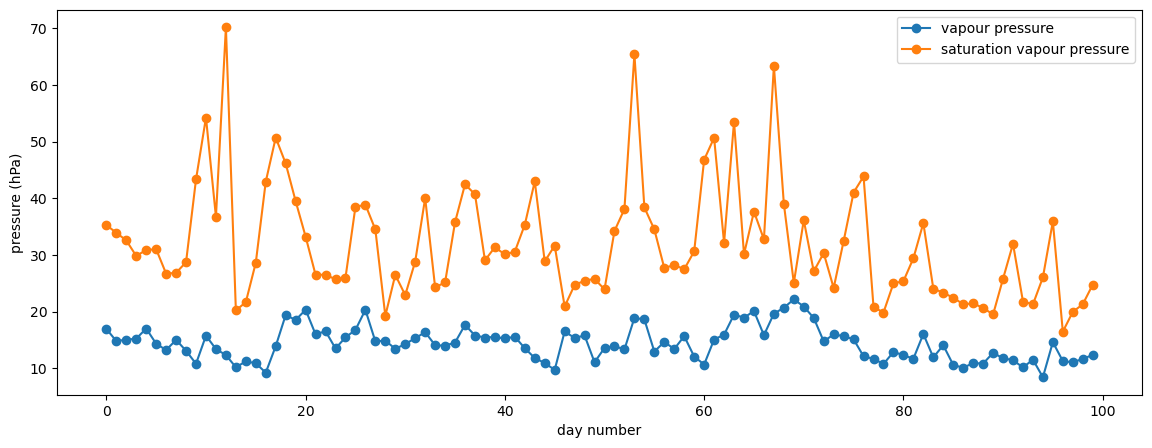

In [48]:
lat, lon = city_lat_lon['Melbourne']
point_vp = da_agcd_vp.sel({'lat': lat, 'lon': lon}, method='nearest')
point_vps = da_agcd_vps.sel({'lat': lat, 'lon': lon}, method='nearest')

fig = plt.figure(figsize=[14, 5])
plt.plot(point_vp.values[1:101], marker='o', label='vapour pressure')
plt.plot(point_vps.values[0:100] / 100, marker='o', label='saturation vapour pressure')

plt.ylabel('pressure (hPa)')
plt.xlabel('day number')
plt.legend()
plt.show()

In [44]:
daily_hurs = (da_agcd_vp[1:].values / (da_agcd_vps.values / 100)) * 100 

In [49]:
coords = {
    'time': ds_agcd_tmin['time'][1:],
    'lat': ds_agcd_tmin['lat'],
    'lon': ds_agcd_tmin['lon'],
}

da_agcd_hurs = xr.DataArray(
    data = daily_hurs,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
)
da_agcd_hurs.attrs['long_name'] = 'Surface relative humidity'
da_agcd_hurs.attrs['units'] = '%'

ds_agcd_hurs = xr.Dataset({'hurs': da_agcd_hurs})

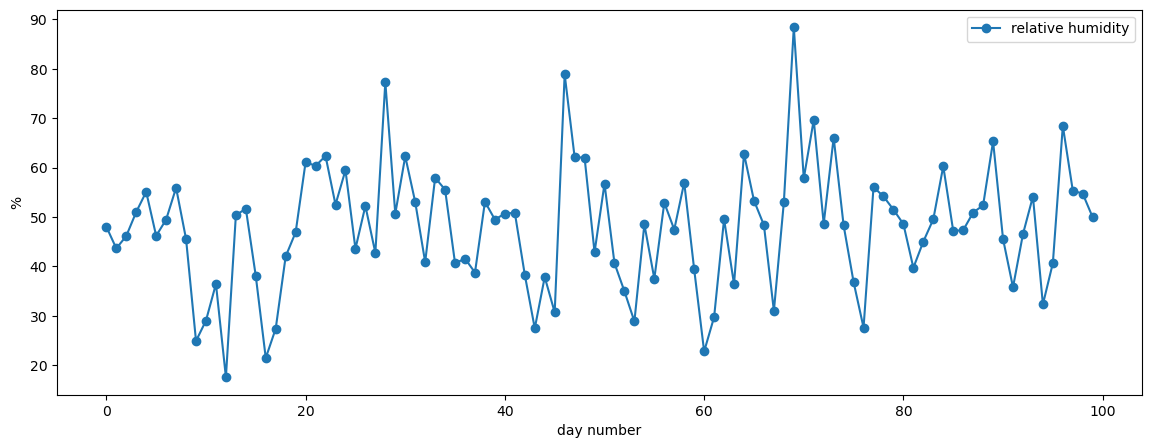

In [57]:
lat, lon = city_lat_lon['Melbourne']
point_hurs = da_agcd_hurs.sel({'lat': lat, 'lon': lon}, method='nearest')

fig = plt.figure(figsize=[14, 5])
plt.plot(point_hurs.values[0:100], marker='o', label='relative humidity')
plt.ylabel('%')
plt.xlabel('day number')
plt.legend()
plt.show()

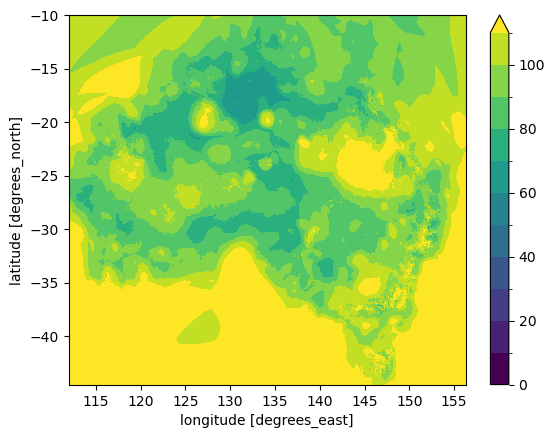

In [56]:
da_agcd_hurs.max('time').plot(levels=[0,10,20,30,40,50,60,70,80,90,100,110])

TODO: Add BARRA2 hurs: 
```
/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/hurs/hurs_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*
```